# 锚框

锚框，也被称为先验框（Prior Box），是一组预定义的矩形框，每个框都有特定的大小和长宽比。这些框被放置在图像的不同位置，以覆盖可能包含物体的区域。锚框是一种生成候选区域的方法，为模型提供了目标的不同尺寸和纵横比的假设。

### 锚框的应用

锚框在目标检测任务中的应用如下：

1. **生成候选区域：** 锚框根据其尺寸和长宽比被放置在图像的不同位置。这些框覆盖了多个可能包含目标的区域，从而生成了候选区域。

2. **目标匹配：** 模型使用锚框来与实际目标进行匹配。通过计算每个锚框与真实目标之间的重叠度，可以确定哪些锚框包含物体。

3. **位置回归：** 锚框不仅用于检测目标，还用于定位目标的精确位置。通过与实际目标的重叠度计算，模型可以学习如何调整锚框以更准确地定位目标。

### 锚框的参数

锚框的参数包括：

- **尺寸（Sizes）：** 锚框的不同尺寸，例如小、中、大。

- **长宽比（Aspect Ratios）：** 锚框的不同纵横比，例如正方形、宽矩形、高矩形。

### 多尺度和多纵横比

为了适应不同大小和形状的目标，通常会使用多尺度和多纵横比的锚框。这意味着在图像上放置不同尺寸和纵横比的锚框，以便检测各种类型的目标。

### 锚框的生成方法

锚框的生成通常依赖于模型架构。一些流行的目标检测架构，如Faster R-CNN和SSD，使用卷积神经网络（CNN）来生成锚框，而另一些方法可能采用不同的策略。

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

# 设置打印选项,精度为小数点后两位
torch.set_printoptions(2)

## 生成多个锚框

In [53]:
def multibox_prior(data, sizes, ratios):
    """
    生成用于目标检测的锚框(anchor boxes)的坐标。

    Parameters:
        data (Tensor): 输入数据，通常是包含图像的张量。
        sizes (list of float): 锚框的尺寸列表。
        ratios (list of float): 锚框的长宽比（宽度除以高度）列表。

    Returns:
        Tensor: 包含生成的锚框坐标的张量。形状为(1, num_anchors, 4),其中num_anchors是锚框的数量。
    """
    # 获取输入图像的高度和宽度
    in_height, in_width = data.shape[-2:]

    # 获取计算设备以及锚框尺寸和长宽比的数量
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)

    # 每个像素生成的锚框数量
    boxes_per_pixel = (num_sizes + num_ratios - 1)

    # 创建包含锚框尺寸和长宽比的张量
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 偏移量和步幅计算
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height
    steps_w = 1.0 / in_width

    # 计算锚框的中心点坐标（所有像素的中心点）
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w

    # 创建网格矩阵，包含所有像素点的中心坐标
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 计算锚框的宽度和高度
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]), sizes[0] / torch.sqrt(ratio_tensor[1:])))

    # 计算锚框的偏移和位置
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    # 计算最终的锚框坐标
    output = out_grid + anchor_manipulations

    # 返回锚框坐标，添加一个额外的维度
    return output.unsqueeze(0)


In [52]:
offset_h, offset_w = 0.5, 0.5
width, height = 30, 20
sizes = [450.0, 300.0, 150.0]
ratios = [0.5, 1, 2]
size_tensor = torch.tensor(sizes)
ratio_tensor = torch.tensor(ratios)
boxes_per_pixel = 5
center_h = torch.arange(height) + offset_h
center_w = torch.arange(width) + offset_w
x, y = torch.meshgrid(center_h,center_w)
x, y = x.reshape(-1), y.reshape(-1)
w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), sizes[0] * torch.sqrt(ratio_tensor[1:]))) * (height/ width)
h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]), sizes[0] / torch.sqrt(ratio_tensor[1:])))
print(w,h)
anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(height * width, 1) / 2
out_grid = torch.stack([x,y,x,y],dim=1).repeat_interleave(boxes_per_pixel, dim=0)

out_put = anchor_manipulations + out_grid
out_grid.size(), anchor_manipulations.size(), out_put.size()


tensor([212.13, 141.42,  70.71, 300.00, 424.26]) tensor([636.40, 424.26, 212.13, 450.00, 318.20])


(torch.Size([3000, 4]), torch.Size([3000, 4]), torch.Size([3000, 4]))

In [54]:
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
X = torch.rand(size=(1, 3, h, w))
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

torch.Size([1, 2042040, 4])

In [55]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

In [48]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """
    在图像上显示所有边界框。

    参数:
    axes (matplotlib.axes._axes.Axes): 用于绘图的轴对象。
    bboxes (list of Tensor): 边界框的坐标,每个边界框为一个长度为4的张量。
    labels (list of str, optional): 每个边界框的标签。
    colors (list of str, optional): 每个边界框的显示颜色。如果没有提供,将使用默认颜色列表。

    返回:
    无
    """
    # 定义一个辅助函数,确保参数是列表或元组,如果不是,则转换为列表
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    # 将传入的标签和颜色参数转换为列表(如果不是列表或元组的话)
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    # 遍历每个边界框并在图像上绘制
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]  # 获取当前边界框的显示颜色
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)  # 将边界框坐标转换为矩形
        axes.add_patch(rect)  # 在轴上添加矩形
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'  # 文本标签的颜色与背景颜色相反
            # 在矩形中心位置添加文本标签
            axes.text(rect.xy[0], rect.xy[1], labels[i], va='center', ha='center', 
                      fontsize=9, color=text_color, bbox=dict(facecolor=color, lw=0))

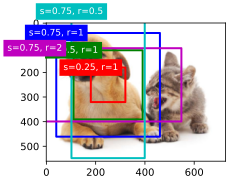

In [49]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2','s=0.75, r=0.5'])

## 交并比(IoU)

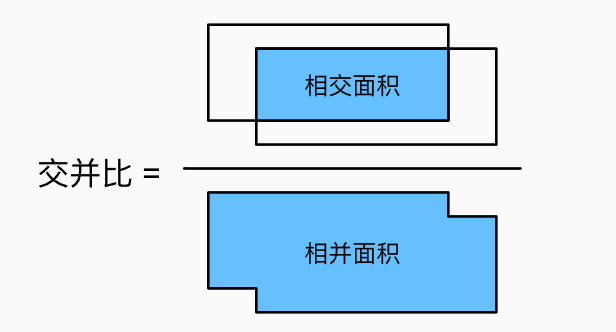

In [89]:
def box_iou(boxes1, boxes2):
    """
    计算两组边界框的交并比(IoU)。

    Parameters:
        boxes1 (Tensor): 包含第一组边界框的张量，每行表示一个边界框的左上角和右下角坐标，形状为 (n, 4)。
        boxes2 (Tensor): 包含第二组边界框的张量，每行表示一个边界框的左上角和右下角坐标，形状为 (m, 4)。

    Returns:
        Tensor: 包含两组边界框的交并比的张量，形状为 (n, m)。
    """
    # 定义一个计算框的面积的函数
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1]))
    
    # 计算输入框 boxes1 和 boxes2 的面积
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)

    # 计算两组框的交集的左上角和右下角坐标
    # boxes1扩展成一个三维张量--让 boxes1 的每个边界框都能与 boxes2 中的每个边界框进行比较
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    # 计算交集的宽度和高度，并确保它们都是非负的
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)

    # 计算交集的面积
    inter_areas = inters[:, :, 0] * inters[:, :, 1]

    # 计算两组框的并集的面积
    union_areas = areas1[:, None] + areas2 - inter_areas

    # 计算并返回框的交并比
    return inter_areas / union_areas


## 将真实边界框分配给锚框

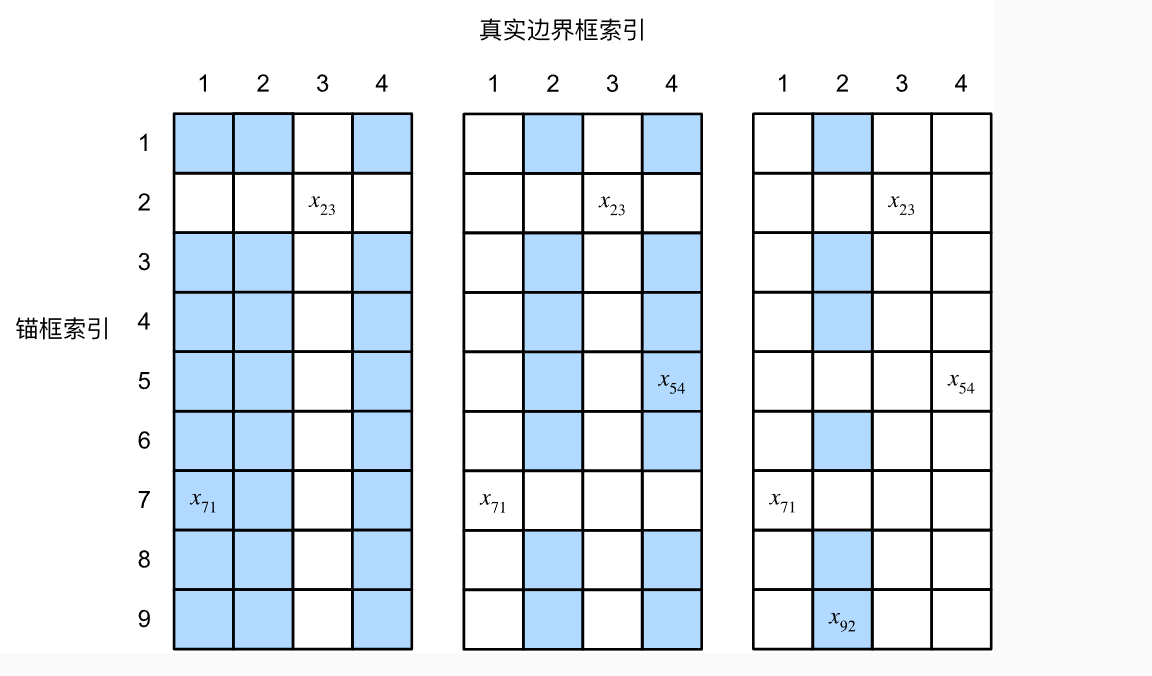

In [31]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """
    将锚框分配给真实边界框。

    参数:
        ground_truth (Tensor): 包含真实边界框的张量，每行表示一个边界框的左上角和右下角坐标，形状为 (n, 4)。
        anchors (Tensor): 包含锚框的张量，每行表示一个锚框的左上角和右下角坐标，形状为 (m, 4)。
        device (torch.device): 计算设备，通常是 GPU 或 CPU。
        iou_threshold (float): 交并比(IoU)阈值,用于确定分配给哪个真实边界框。默认值为 0.5。

    返回:
        Tensor: 一个包含锚框分配给真实边界框的索引的张量，形状为 (m,)。
    """
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 创建一个形状为 (num_anchors,) 的张量 anchors_bbox_map,并将其填充为 -1,用于表示初始时每个锚框尚未被分配给任何真实边界框。
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)
    # 计算每个锚框与所有真实边界框之间的最大交并比,并返回这些最大交并比以及对应的真实边界框的索引
    max_ious, indices = torch.max(jaccard, dim=1)
    # 找出与满足交并比大于等于阈值的锚框相关联的锚框索引,并将索引展平为一维数组
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    # 从索引列表中选择满足特定 IOU 阈值的真实边界的索引(indices表示索引[0,1,2,3,4....])
    box_j = indices[max_ious >= iou_threshold]
    # 在匹配好的锚框anc_i处记录其匹配的真实边界框索引box_j
    anchors_bbox_map[anc_i] = box_j
    # col_discard表示每个anchor是否被匹配过
    col_discard = torch.full((num_anchors,), -1)
    # row_discard表示每个gt框是否被匹配过
    row_discard = torch.full((num_gt_boxes,), -1)
    # 外循环,对每个gt框都找到一个匹配的anchor
    for _ in range(num_gt_boxes):
        # 在整个cost matrix中找出当前最大值的索引-矩阵大小：(num_anchors, num_gt_boxes)
        max_idx = torch.argmax(jaccard)
        # 通过取余数,从索引中解析出对应gt框的序号
        box_idx = (max_idx % num_gt_boxes).long()
        # 通过整除,从索引中解析出对应anchor的序号
        anc_idx = (max_idx / num_gt_boxes).long()
        # 在anchor映射表中填入(anchor序号,gt序号)的匹配信息
        anchors_bbox_map[anc_idx] = box_idx
        # 将该gt框对应的列标记为已匹配过
        jaccard[:, box_idx] = col_discard
        # 将该anchor对应的行标记为已匹配过
        jaccard[anc_idx, :] = row_discard

    return anchors_bbox_map

In [16]:
# 测试torch.max在不同维度的结果
test = torch.tensor([[[1, 2, 3, 4],
                      [4, 1, 22, 8]],
                     [[10, 11, 12, 13],
                      [15, 16, 17, 18]]])
torch.max(test, dim=0)

torch.return_types.max(
values=tensor([[10, 11, 12, 13],
        [15, 16, 22, 18]]),
indices=tensor([[1, 1, 1, 1],
        [1, 1, 0, 1]]))

In [29]:
# 测试通过布尔值来索引元素
max_ious = torch.tensor([0.2, 0.7, 0.6, 0.8, 0.4])  # 最大交并比
iou_threshold = 0.5  # 设定的IoU阈值
print(max_ious > iou_threshold, torch.nonzero(max_ious > iou_threshold).reshape(-1))
index = torch.tensor([0, 1, 2, 3, 4])
index[max_ious > iou_threshold]

tensor([False,  True,  True,  True, False]) tensor([1, 2, 3])


tensor([1, 2, 3])

In [28]:
# 张量索引技术
map = torch.full((6,), -1, dtype=torch.long)
a = torch.tensor([0, 1, 2, 3, 4, 5])
b = torch.tensor([11, 12, 13, 14, 15, 222])
map[a] = b

print(map)

tensor([ 11,  12,  13,  14,  15, 222])


In [31]:
import torch
jaccard = torch.tensor([[0.1, 0.2, 0.3],
                        [0.4, 0.5, 0.6],
                        [0.7, 0.8, 0.9],
                        [0.2, 0.3, 0.4],
                        [0.6, 0.7, 0.8]])

num_anchors = 5
num_gt_boxes = 3

col_discard = torch.full((num_anchors,), -1)
row_discard = torch.full((num_gt_boxes,), -1)

anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long)

for _ in range(num_gt_boxes):
    max_idx = torch.argmax(jaccard)
    print(max_idx)
    box_idx = (max_idx % num_gt_boxes).long()
    anc_idx = (max_idx / num_gt_boxes).long()
    anchors_bbox_map[anc_idx] = box_idx
    jaccard[:, box_idx] = col_discard
    print(jaccard)
    jaccard[anc_idx, :] = row_discard
    print(jaccard)
print(anchors_bbox_map)


tensor(8)
tensor([[ 0.10,  0.20, -1.00],
        [ 0.40,  0.50, -1.00],
        [ 0.70,  0.80, -1.00],
        [ 0.20,  0.30, -1.00],
        [ 0.60,  0.70, -1.00]])
tensor([[ 0.10,  0.20, -1.00],
        [ 0.40,  0.50, -1.00],
        [-1.00, -1.00, -1.00],
        [ 0.20,  0.30, -1.00],
        [ 0.60,  0.70, -1.00]])
tensor(13)
tensor([[ 0.10, -1.00, -1.00],
        [ 0.40, -1.00, -1.00],
        [-1.00, -1.00, -1.00],
        [ 0.20, -1.00, -1.00],
        [ 0.60, -1.00, -1.00]])
tensor([[ 0.10, -1.00, -1.00],
        [ 0.40, -1.00, -1.00],
        [-1.00, -1.00, -1.00],
        [ 0.20, -1.00, -1.00],
        [-1.00, -1.00, -1.00]])
tensor(3)
tensor([[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]])
tensor([[-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.],
        [-1., -1., -1.]])
tensor([-1,  0,  2, -1,  1])


## 标记类别和偏移量

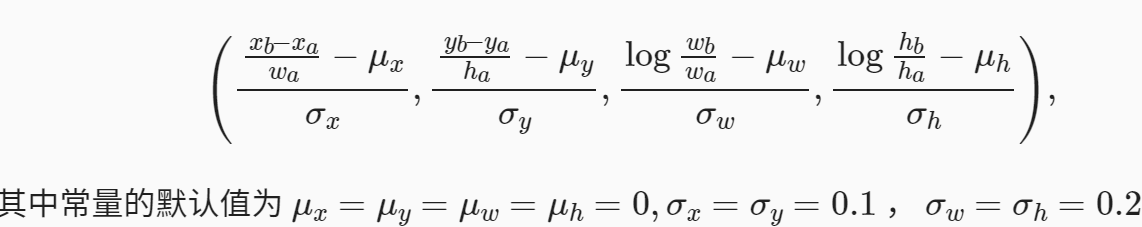

In [32]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """
    对锚框偏移量的转换。

    参数:
        anchors:锚框的张量。
        assigned_bb:与锚框匹配的目标框的张量。
        eps:一个很小的常数,用于避免除零错误。

    返回:
        offset:对锚框偏移量的转换,以便将其转换为目标框。
    """
    # 将锚框和目标框的中心点转换为归一化坐标。
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    # 计算锚框和目标框的宽度和高度的偏移量。
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    # 将宽度和高度的偏移量合并为一个张量。
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [33]:
def multibox_target(anchors, labels):
    """
    使用真实边界框标记锚框。

    参数:
        anchors:锚框的张量。(num_anchors, 4)
        labels:标签的张量。(batch_size, num_labels, 5)--其中每个标签包含 [class, x_min, y_min, x_max, y_max]

    返回:
        bbox_offset:对锚框偏移量的转换,以便将其转换为目标框。
        bbox_mask:一个张量,表示每个锚框是否被分配。
        class_labels:一个张量,表示每个锚框的类别。
    """
    # 获取批量大小和锚框的数量
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    # 初始化用于存储输出的列表
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        # 获取当前批量中的标签。
        label = labels[i, :, :]
        # 分配锚框到目标框，得到映射
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        # 创建一个掩码，用于指示每个锚框是否被分配
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # 初始化存储类别标签和边界框偏移的数组
        class_labels = torch.zeros(num_anchors, dtype=torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        # 找到与目标框匹配的锚框的索引
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景(值为零)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        # 为匹配的锚框分配类别标签
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        # 为匹配的锚框分配边界框坐标
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 计算锚框偏移量
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        # 将偏移量、掩码和类标签添加到输出列表中
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    # 将输出列表转换为张量
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [ ]:
def multibox_target(anchors, labels):
    """
    生成目标检测任务的训练目标（标签）。

    Parameters:
        anchors (ndarray): 形状为 (num_anchors, 4) 的锚框数组。
        labels (ndarray): 形状为 (batch_size, num_labels, 5) 的标签数组，
            其中每个标签包含 [class, x_min, y_min, x_max, y_max]。

    Returns:
        Tuple[ndarray, ndarray, ndarray]: 包含边界框偏移、二进制掩码和类别标签的元组。
            - 边界框偏移 (bbox_offset): 形状为 (batch_size, num_anchors * 4) 的数组。
            - 二进制掩码 (bbox_mask): 形状为 (batch_size, num_anchors * 4) 的数组。
            - 类别标签 (class_labels): 形状为 (batch_size, num_anchors) 的数组。
    """
    # 获取批量大小和压缩锚框维度
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    
    # 初始化用于存储结果的列表
    batch_offset, batch_mask, batch_class_labels = [], [], []
    
    # 获取设备和锚框数量
    device, num_anchors = anchors.ctx, anchors.shape[0]
    
    # 遍历每个批次的标签
    for i in range(batch_size):
        label = labels[i, :, :]
        
        
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        
        # 创建一个二进制掩码以指示哪些锚框与目标框匹配
        bbox_mask = np.tile((np.expand_dims((anchors_bbox_map >= 0), axis=-1)), (1, 4)).astype('int32')
        
        # 初始化存储类别标签和边界框偏移的数组
        class_labels = np.zeros(num_anchors, dtype=np.int32, ctx=device)
        assigned_bb = np.zeros((num_anchors, 4), dtype=np.float32, ctx=device)
        
        
        indices_true = np.nonzero(anchors_bbox_map >= 0)[0]
        bb_idx = anchors_bbox_map[indices_true]
        
        # 为匹配的锚框分配类别标签
        class_labels[indices_true] = label[bb_idx, 0].astype('int32') + 1
        
        
        assigned_bb[indices_true] = label[bb_idx, 1:]
        
        # 计算偏移量并应用二进制掩码
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        
        # 将结果添加到批量的列表中
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    
    # 将列表转换为 NumPy 数组
    bbox_offset = np.stack(batch_offset)
    bbox_mask = np.stack(batch_mask)
    class_labels = np.stack(batch_class_labels)
    
    # 返回结果，包括边界框偏移、二进制掩码和类别标签
    return (bbox_offset, bbox_mask, class_labels)


## 一个例子

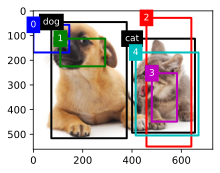

In [34]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                             [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], 
                        [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], 
                        [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [35]:
labels = multibox_target(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

In [36]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

In [37]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [38]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

## 使用非极大值抑制预测边界框

In [39]:
def offset_inverse(anchors, offset_preds):
    """
    根据带有预测偏移量的锚框来预测边界框。

    参数:
        anchors:锚框的张量。
        offset_preds:预测偏移量的张量。

    返回:
        predicted_bbox:预测的边界框的张量。
    """
    # 将锚框的中心点转换为归一化坐标
    anc = d2l.box_corner_to_center(anchors)
    # 计算边界框的宽度和高度的预测偏移量
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    # 将宽度和高度的偏移量合并为一个张量
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    # 将边界框的中心点从归一化坐标转换为像素坐标
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

In [40]:
def nms(boxes, scores, iou_threshold):
    """
    非极大值抑制(NMS)是一种用于从预测边界框中去除重叠边界框的算法。

    参数:
        boxes:预测边界框的张量。
        scores:预测边界框的置信度张量。
        iou_threshold:两个边界框之间的交并比(IoU)阈值。

    返回:
        keep:保留的预测边界框的指标张量。
    """
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4), boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

In [41]:
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引,并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

In [42]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], 
                        [0.08, 0.2, 0.56, 0.95],
                        [0.15, 0.3, 0.62, 0.91], 
                        [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

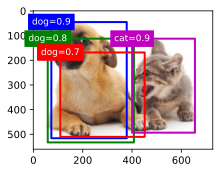

In [43]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale, ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

In [44]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

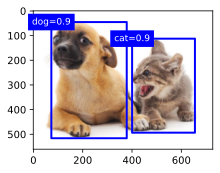

In [45]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)